In [ ]:
!nvidia-smi -L

GPU 0: Tesla P4 (UUID: GPU-240b1391-9d21-3fd4-2fba-d6e24bf276f9)


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Mounting successful. Locate the dataset directory and create data generator

In [ ]:
ROOT_DIR = "/content/gdrive/MyDrive/Brats_dataset"
import os
os.listdir(ROOT_DIR)

['MICCAI_BraTS2020_TrainingData']

In [ ]:
from tqdm import tqdm
import os


import numpy as np

import nibabel as nib
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import backend as K

from tensorflow.keras import Input
from tensorflow.keras import initializers

from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose, 
    BatchNormalization, 
    Activation, 
    MaxPooling2D, 
    UpSampling2D, 
    concatenate, 
    Add,
    Dropout)



from skimage.transform import resize
from skimage import exposure
import cv2

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model, load_model

%matplotlib inline


In [ ]:
def read_image(path):
    image = nib.load(path)
    image = (image.dataobj)
    return np.asarray(image)

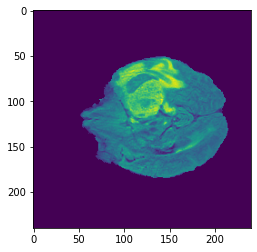

In [ ]:
TRAIN_DATA_PATH = os.path.join(ROOT_DIR, "MICCAI_BraTS2020_TrainingData")

case_id = '001'
case_path = os.path.join(TRAIN_DATA_PATH, f"BraTS20_Training_{case_id}")


flair_voxel = read_image(os.path.join(case_path, f'BraTS20_Training_{case_id}_flair.nii.gz'))
plt.imshow(flair_voxel[..., 60])

In [ ]:
import random
def show_slice(case: str, mode: str, slice_: int = None):
  """
  case : str, three digit index from 001 to 369
  slice_: int, integer slice index ranging from 0 to 154
  mode: str, mode of image, can be one of the five following types (case sensitive)
  - flair
  - t1
  - t1ce
  - t2
  - seg
  """
  case_path = os.path.join(TRAIN_DATA_PATH, f'BraTS20_Training_{case}')
  voxel_path = os.path.join(case_path, f'BraTS20_Training_{case}_{mode}.nii.gz')
  voxel = read_image(voxel_path)
  if slice_ is None: 
    slice_ = random.randint(0, 156)
    
  img = voxel[..., slice_]
  plt.imshow(img, cmap="gray")
  return img


So far everything works fine on the google colab.

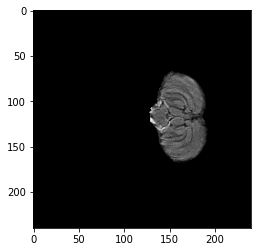

In [ ]:
img = show_slice(case='120', mode='flair', slice_=20)

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, spatient_IDs, dim=(128,128), start_slice = 20, z_range = 120, batch_size = 1, n_channels = 4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = spatient_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.__start_slice = start_slice
        self.__z_range = z_range
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size * self.__z_range, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * self.__z_range, 240, 240))
        Y = np.zeros((self.batch_size * self.__z_range, *self.dim, 4))


        
        # Generate data
        
        # Output is input image (normalized) & label as one-hot vector [a, b, c, d]
        # a --> not tumour (for 0 pixels)
        # b --> necrotic (for 1 pixels)
        # c --> edema (for 2 pixels)
        # d --> 


        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATA_PATH, i)

            flair_path = os.path.join(case_path, f'{i}_flair.nii.gz')
            flair =read_image(flair_path)      

            t1_path = os.path.join(case_path, f'{i}_t1.nii.gz')
            t1 =read_image(t1_path)

            t1ce_path = os.path.join(case_path, f'{i}_t1ce.nii.gz')
            ce =read_image(t1ce_path)
            
            t2_path = os.path.join(case_path, f'{i}_t2.nii.gz')
            t2 =read_image(t2_path)

            seg_path = os.path.join(case_path, f'{i}_seg.nii.gz')
            seg =read_image(seg_path)
        
            for j in range(self.__z_range):
                X[j + self.__z_range * c, :, :, 0] = cv2.resize(flair[:, :, j + self.__start_slice], self.dim)
                X[j + self.__z_range * c, :, :, 1] = cv2.resize(t1[:, :, j + self.__start_slice], self.dim)
                X[j + self.__z_range * c, :, :, 2] = cv2.resize(ce[:, :, j + self.__start_slice], self.dim)
                X[j + self.__z_range * c, :, :, 3] = cv2.resize(t2[:, :, j + self.__start_slice], self.dim)

                y[j + self.__z_range * c] = seg[:, :, j + self.__start_slice];
                    
            #=============Preprocess masks===========
        y[ y == 4 ] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, self.dim)

        # X = cv2.normalize(X, None, alpha=0, beta=255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        return X/np.max(X), Y

In [ ]:
from sklearn.model_selection import train_test_split
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATA_PATH) if f.is_dir()]
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(os.path.join(TRAIN_DATA_PATH, 'BraTS20_Training_355'))


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

train_val_ids, test_ids = train_test_split(train_and_test_ids,test_size=0.15, shuffle=True) 
train_ids, val_ids = train_test_split(train_val_ids,test_size=0.2, shuffle=True) 

print(f"train size: {len(train_ids)}, validation size: {len(val_ids)}, test size: {len(test_ids)}")

train size: 249, validation size: 63, test size: 56


In [ ]:
train_gen = DataGenerator(train_ids)
valid_gen = DataGenerator(val_ids)
test_gen = DataGenerator(test_ids)

In [ ]:
X, y = train_gen[0]

y.shape

TensorShape([120, 128, 128, 4])

### Model creation, Unet 2D with minor adjustments

Instead of using Unet 2D baseline, we can use some altercations. 
1. Use dropout layers in between.
2. Use elementwise sum instead of channelwise concatenation
3. Use dice loss instead of categorical crossentropy

In [ ]:
# metrics

def dice_coef(y_true, y_pred, smooth=1.0):
    ''' Dice Coefficient
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''

    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def dice_coef_loss(y_true, y_pred):
    ''' Dice Coefficient Loss
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    return 1-dice_coef(y_true, y_pred)

In [ ]:
X, y = train_gen[0]
iou = tf.metrics.MeanIoU(num_classes=4)
iou(y, y)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [ ]:
def build_unet_baseline(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same',
                kernel_initializer=ker_init)(conv5),conv4], axis=3)
    

    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same',
                   kernel_initializer=ker_init)(up6)

    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same',
                   kernel_initializer=ker_init)(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',
                kernel_initializer=ker_init)(conv6), conv3], axis=3)

    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same',
                   kernel_initializer=ker_init)(up7)

    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same',
                   kernel_initializer=ker_init)(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2),padding='same',
                kernel_initializer=ker_init)(conv7), conv2], axis=3)
    
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same',
                   kernel_initializer=ker_init)(up8)

    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same',
                   kernel_initializer=ker_init)(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same',
                kernel_initializer=ker_init)(conv8), conv1], axis=3)
    

    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same',
                   kernel_initializer=ker_init)(up9)

    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same',
                   kernel_initializer=ker_init)(conv9)

    conv10 = Conv2D(4, (1, 1), activation='relu',
                    kernel_initializer=ker_init)(conv9)
                    
    conv10 = Activation('softmax')(conv10)
    
    return Model(inputs = inputs, outputs = conv10)

In [ ]:
K.clear_session()

In [ ]:
input_layer = Input((128, 128, 4))

ker_init = 'he_normal'
# ker_init = initializers.random_normal(stddev=0.01)

unet_baseline = build_unet_baseline(input_layer, ker_init, 0.2)
unet_baseline.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
def plot_model(model_obj: tf.keras.Model, filename: str):
    return tf.keras.utils.plot_model(
        model_obj,
        to_file=filename,
        show_shapes=True,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=70,
    )

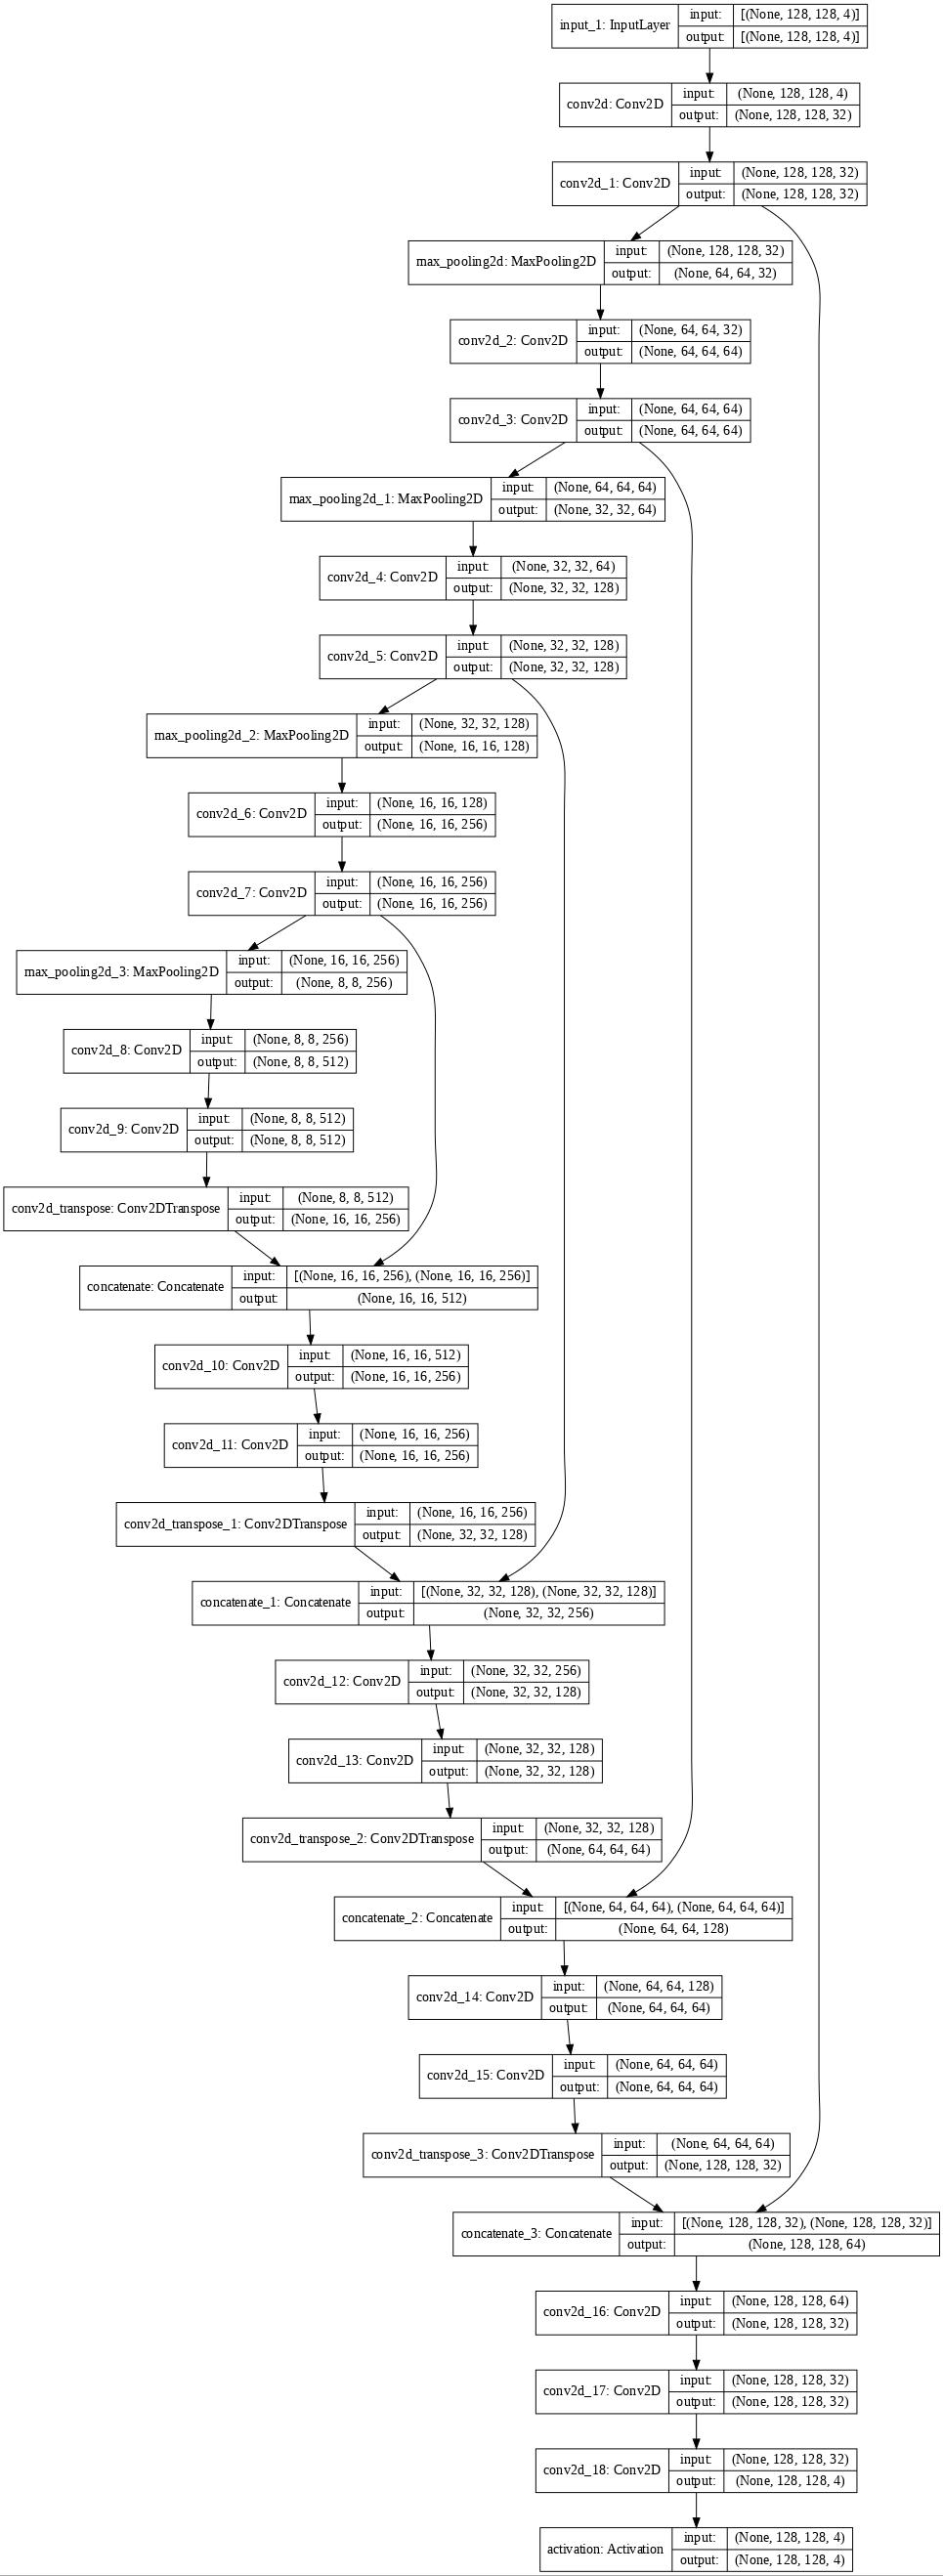

In [ ]:
plot_model(unet_baseline, filename="unet_baseline.jpg")

In [ ]:
unet_baseline.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-04), 
                    loss = 'categorical_crossentropy', 
                    metrics = ["accuracy", dice_coef, tf.metrics.MeanIoU(num_classes=4)]
)

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger('training_unet2d_baseline_new.csv', separator=',', append=True)
checkpoint_filepath = 'unet2d_baseline.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint( 
    filepath=checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", patience=10, factor=0.2, verbose=1, min_lr=1e-06),
    csv_logger,
    model_checkpoint
]

In [ ]:
results = unet_baseline.fit(
    train_gen,
    epochs=50,
    steps_per_epoch=len(train_ids),  
    validation_data = valid_gen,
    callbacks= callbacks
)

Epoch 1/50
249/249 [==============================] - 944s 4s/step - loss: 0.1191 - accuracy: 0.9820 - dice_coef: 0.4981 - mean_io_u: 0.5909 - val_loss: 0.0565 - val_accuracy: 0.9859 - val_dice_coef: 0.5162 - val_mean_io_u: 0.5779
Epoch 2/50
249/249 [==============================] - 218s 875ms/step - loss: 0.0536 - accuracy: 0.9856 - dice_coef: 0.5362 - mean_io_u: 0.6532 - val_loss: 0.0403 - val_accuracy: 0.9862 - val_dice_coef: 0.5497 - val_mean_io_u: 0.6493
Epoch 3/50
249/249 [==============================] - 218s 875ms/step - loss: 0.0401 - accuracy: 0.9869 - dice_coef: 0.5587 - mean_io_u: 0.7021 - val_loss: 0.0376 - val_accuracy: 0.9881 - val_dice_coef: 0.5557 - val_mean_io_u: 0.7305
Epoch 4/50
249/249 [==============================] - 217s 871ms/step - loss: 0.0366 - accuracy: 0.9882 - dice_coef: 0.5638 - mean_io_u: 0.7225 - val_loss: 0.0331 - val_accuracy: 0.9887 - val_dice_coef: 0.5763 - val_mean_io_u: 0.7118
Epoch 5/50
249/249 [==============================] - 217s 871ms/st

In [ ]:
unet_baseline.save_weights("unet_baseline_new_best.h5")

In [ ]:
K.clear_session()

unet_baseline_1 = build_unet_baseline(input_layer, ker_init, 0.2)
unet_baseline_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-04), 
                    loss = 'categorical_crossentropy', 
                    metrics = ["accuracy", dice_coef, tf.metrics.MeanIoU(num_classes=4)]
)

unet_baseline_1.load_weights("unet_baseline_new_best.h5")

### Baseline Model Unet 2D after 30 epochs gives 62% dice score (training and validation).

We will be using that model to make further predictions.

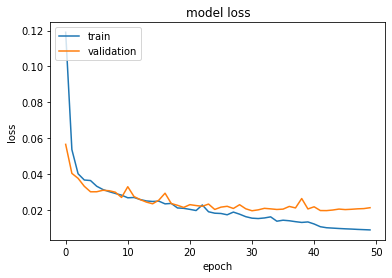

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

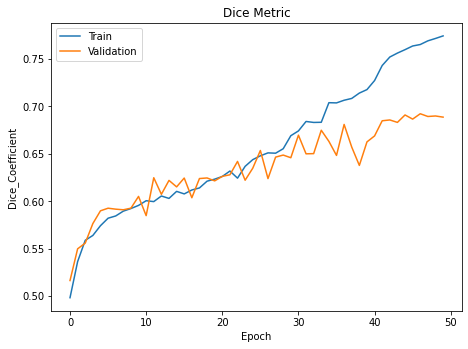

In [ ]:
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('Dice Metric')
plt.ylabel('Dice_Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

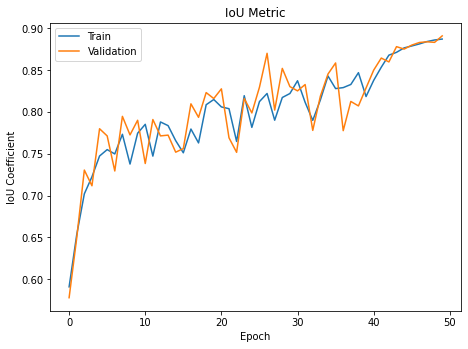

In [ ]:
plt.plot(results.history['mean_io_u'])
plt.plot(results.history['val_mean_io_u'])
plt.title('IoU Metric')
plt.ylabel('IoU Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

In [ ]:
def vol_pred(case, model_obj):
    z_slices = 120
    z_start = 20
    X = np.empty((z_slices, 128, 128, 4))
    case_path = os.path.join(TRAIN_DATA_PATH, f"BraTS20_Training_{case}")
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii.gz')
    flair=read_image(vol_path)

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1.nii.gz')
    t1=read_image(vol_path)
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii.gz')
    ce=read_image(vol_path)   

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t2.nii.gz')
    t2=read_image(vol_path)

    
    for j in range(z_slices):
        X[j,:,:,0] = cv2.resize(flair[:, :, j + z_start], (128,128))
        X[j,:,:,1] = cv2.resize(ce[:, :, j + z_start], (128,128))
    return model_obj.predict(X/np.max(X), verbose=1)



In [ ]:
case = '011'
case_path = os.path.join(TRAIN_DATA_PATH, f"BraTS20_Training_{case}")

prediction = vol_pred(case, unet_baseline_1)
ground_truth = read_image(os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii.gz'))

4/4 [==============================] - 0s 48ms/step


In [ ]:
prediction[prediction >= 0.4] = 1
prediction[prediction <0.4] = 0

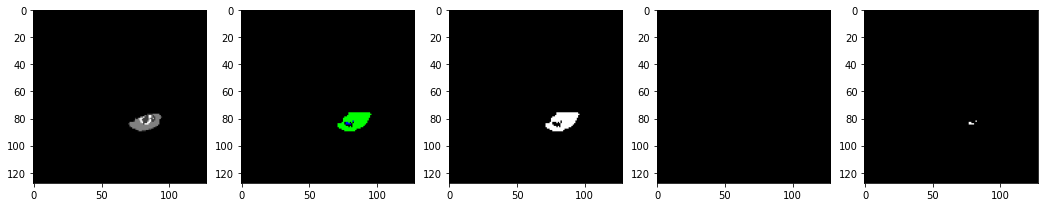

In [ ]:
core = prediction[:,:,:,1]
edema= prediction[:,:,:,2]
enhancing = prediction[:,:,:,3]



f, axarr = plt.subplots(1,5, figsize = (18, 50)) 
s = 40


axarr[0].imshow(cv2.resize(ground_truth[:,:,s+20], (128, 128)), cmap="gray")
axarr[1].imshow(prediction[s,:,:,1:4], cmap="gray")
axarr[2].imshow(edema[s], cmap="gray")
axarr[3].imshow(core[s], cmap="gray")
axarr[4].imshow(enhancing[s], cmap="gray")

In [ ]:
def show_mask_prediction(model_obj, case: str, slice_: int, onehot_gt: bool = False):
    f, ax = plt.subplots(3, 2, figsize=(30, 40))
    case_path = os.path.join(TRAIN_DATA_PATH, f"BraTS20_Training_{case}")

    image_flair = read_image(os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii.gz'))

    image_ce = read_image(os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii.gz'))

    ground_truth = read_image(os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii.gz'))
    
    image_flair = cv2.resize(image_flair, (128, 128))
    image_ce = cv2.resize(image_ce, (128, 128))
    gt = cv2.resize(ground_truth[:, :, slice_+20], (128, 128))
    
    pred_mask = vol_pred(case, model_obj)    # batch_size x 128 x 128 x 3
    
    pred_mask[pred_mask >= 0.4] = 1
    pred_mask[pred_mask <0.4] = 0
    
    
    if onehot_gt:
        gt[gt==4] = 3
        gt = tf.one_hot(gt, 4)
    
    print(gt.shape)
    ax[0][0].imshow(image_flair[:, :, slice_], cmap="gray")
    ax[0][0].set_title("Flair image")
    ax[0][1].imshow(image_flair[:, :, slice_], cmap="gray", interpolation='none')
    ax[0][1].imshow(pred_mask[slice_,:,:,1:4], alpha=0.5, interpolation='none')
    ax[0][1].set_title("Flair image (predicted mask)")
    
    ax[1][0].imshow(image_ce[:, :, slice_], cmap="gray")
    ax[1][0].set_title("t1 ce image")
    ax[1][1].imshow(image_ce[:, :, slice_], cmap="gray", interpolation='none')
    ax[1][1].imshow(pred_mask[slice_,:,:,1:4], alpha=0.5, interpolation='none')
    ax[1][1].set_title("t1 ce image (predicted mask)")
    
    ax[2][0].imshow(image_ce[:, :, slice_], cmap="gray")
    ax[2][0].set_title("Flair image")
    ax[2][1].imshow(image_ce[:, :, slice_], cmap="gray", interpolation='none')
    if onehot_gt:
        ax[2][1].imshow(gt[:, :, 1:4], alpha=0.5, interpolation='none')
    else:
        ax[2][1].imshow(gt, alpha=0.5, interpolation='none')
    ax[2][1].set_title("Flair image (original mask)")

4/4 [==============================] - 0s 45ms/step
(128, 128)


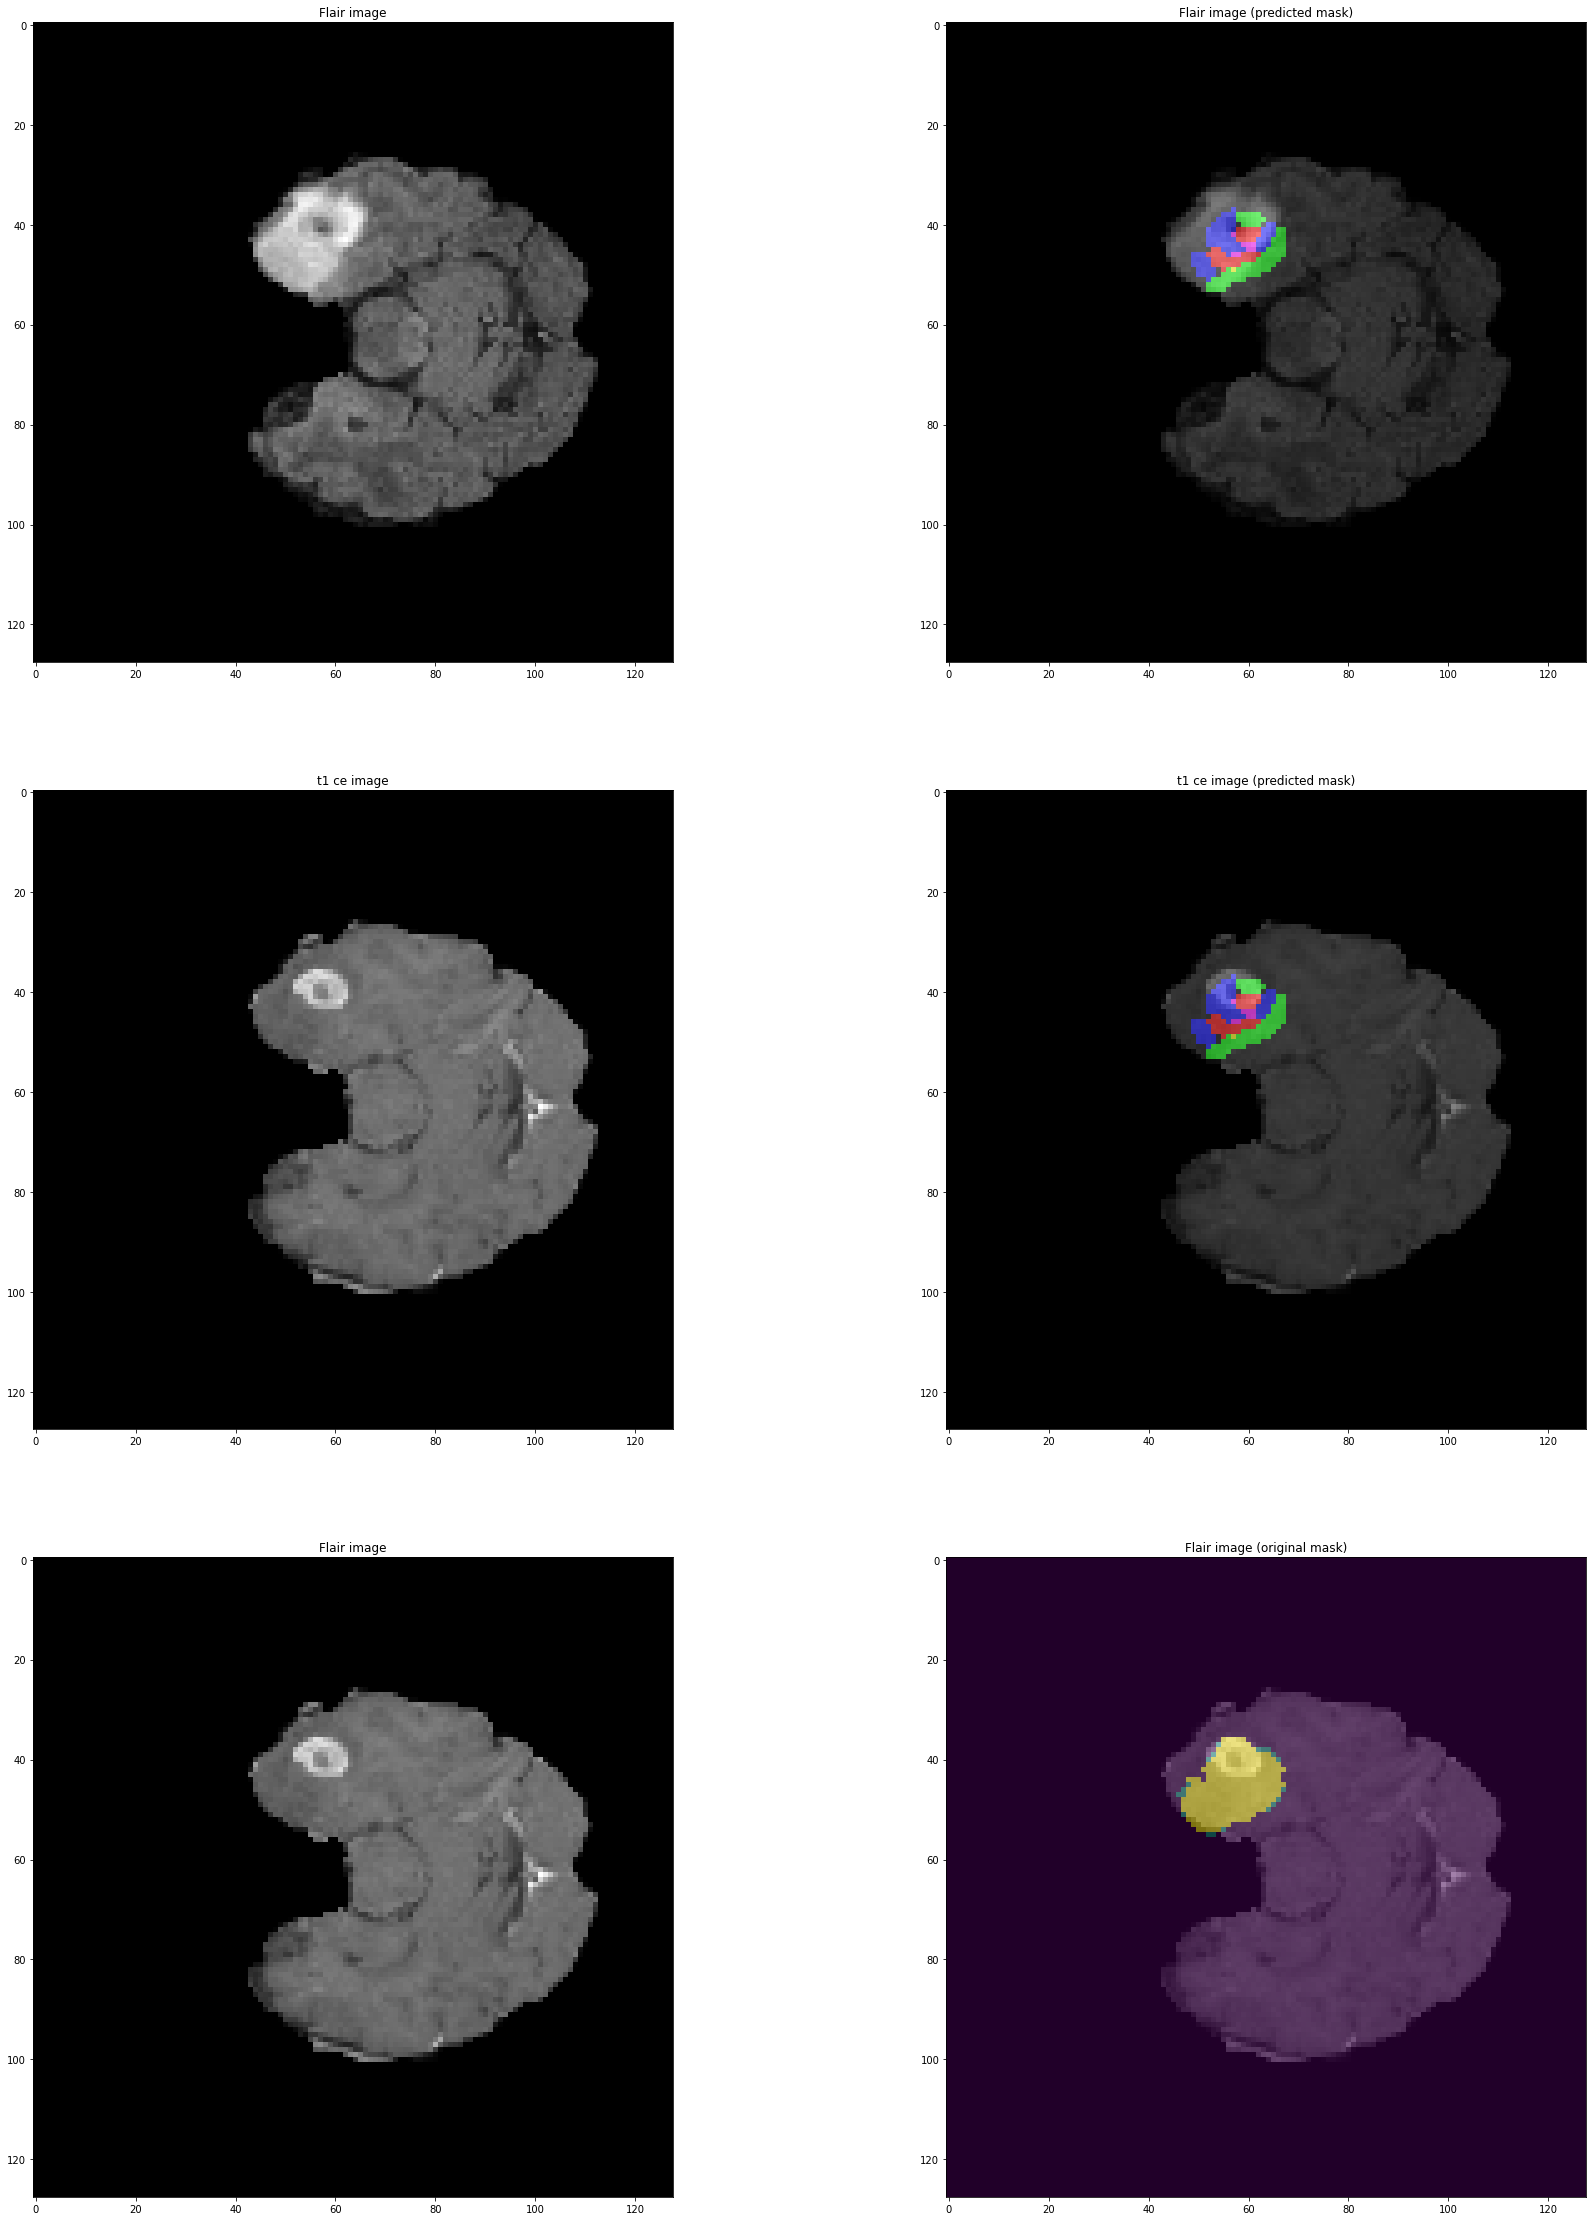

In [ ]:
show_mask_prediction(unet_baseline_1, case='200', slice_=45)

In [ ]:
score = unet_baseline_1.evaluate(test_gen)
type(score)

56/56 [==============================] - 36s 635ms/step - loss: 0.0185 - accuracy: 0.9945 - dice_coef: 0.7102 - mean_io_u: 0.8917


list

In [ ]:
import pickle

loss = score[0]
acc = score[1]
dice = score[2]
iou = score[3]

test_results = {
    "loss": loss,
    "acc": acc,
    "dice": dice,
    "iou": iou
}

with open("test_results.pkl", 'wb') as fl:
  pickle.dump(test_results, fl, protocol=pickle.HIGHEST_PROTOCOL)

BraTS20_Training_033
4/4 [==============================] - 0s 47ms/step
(128, 128)


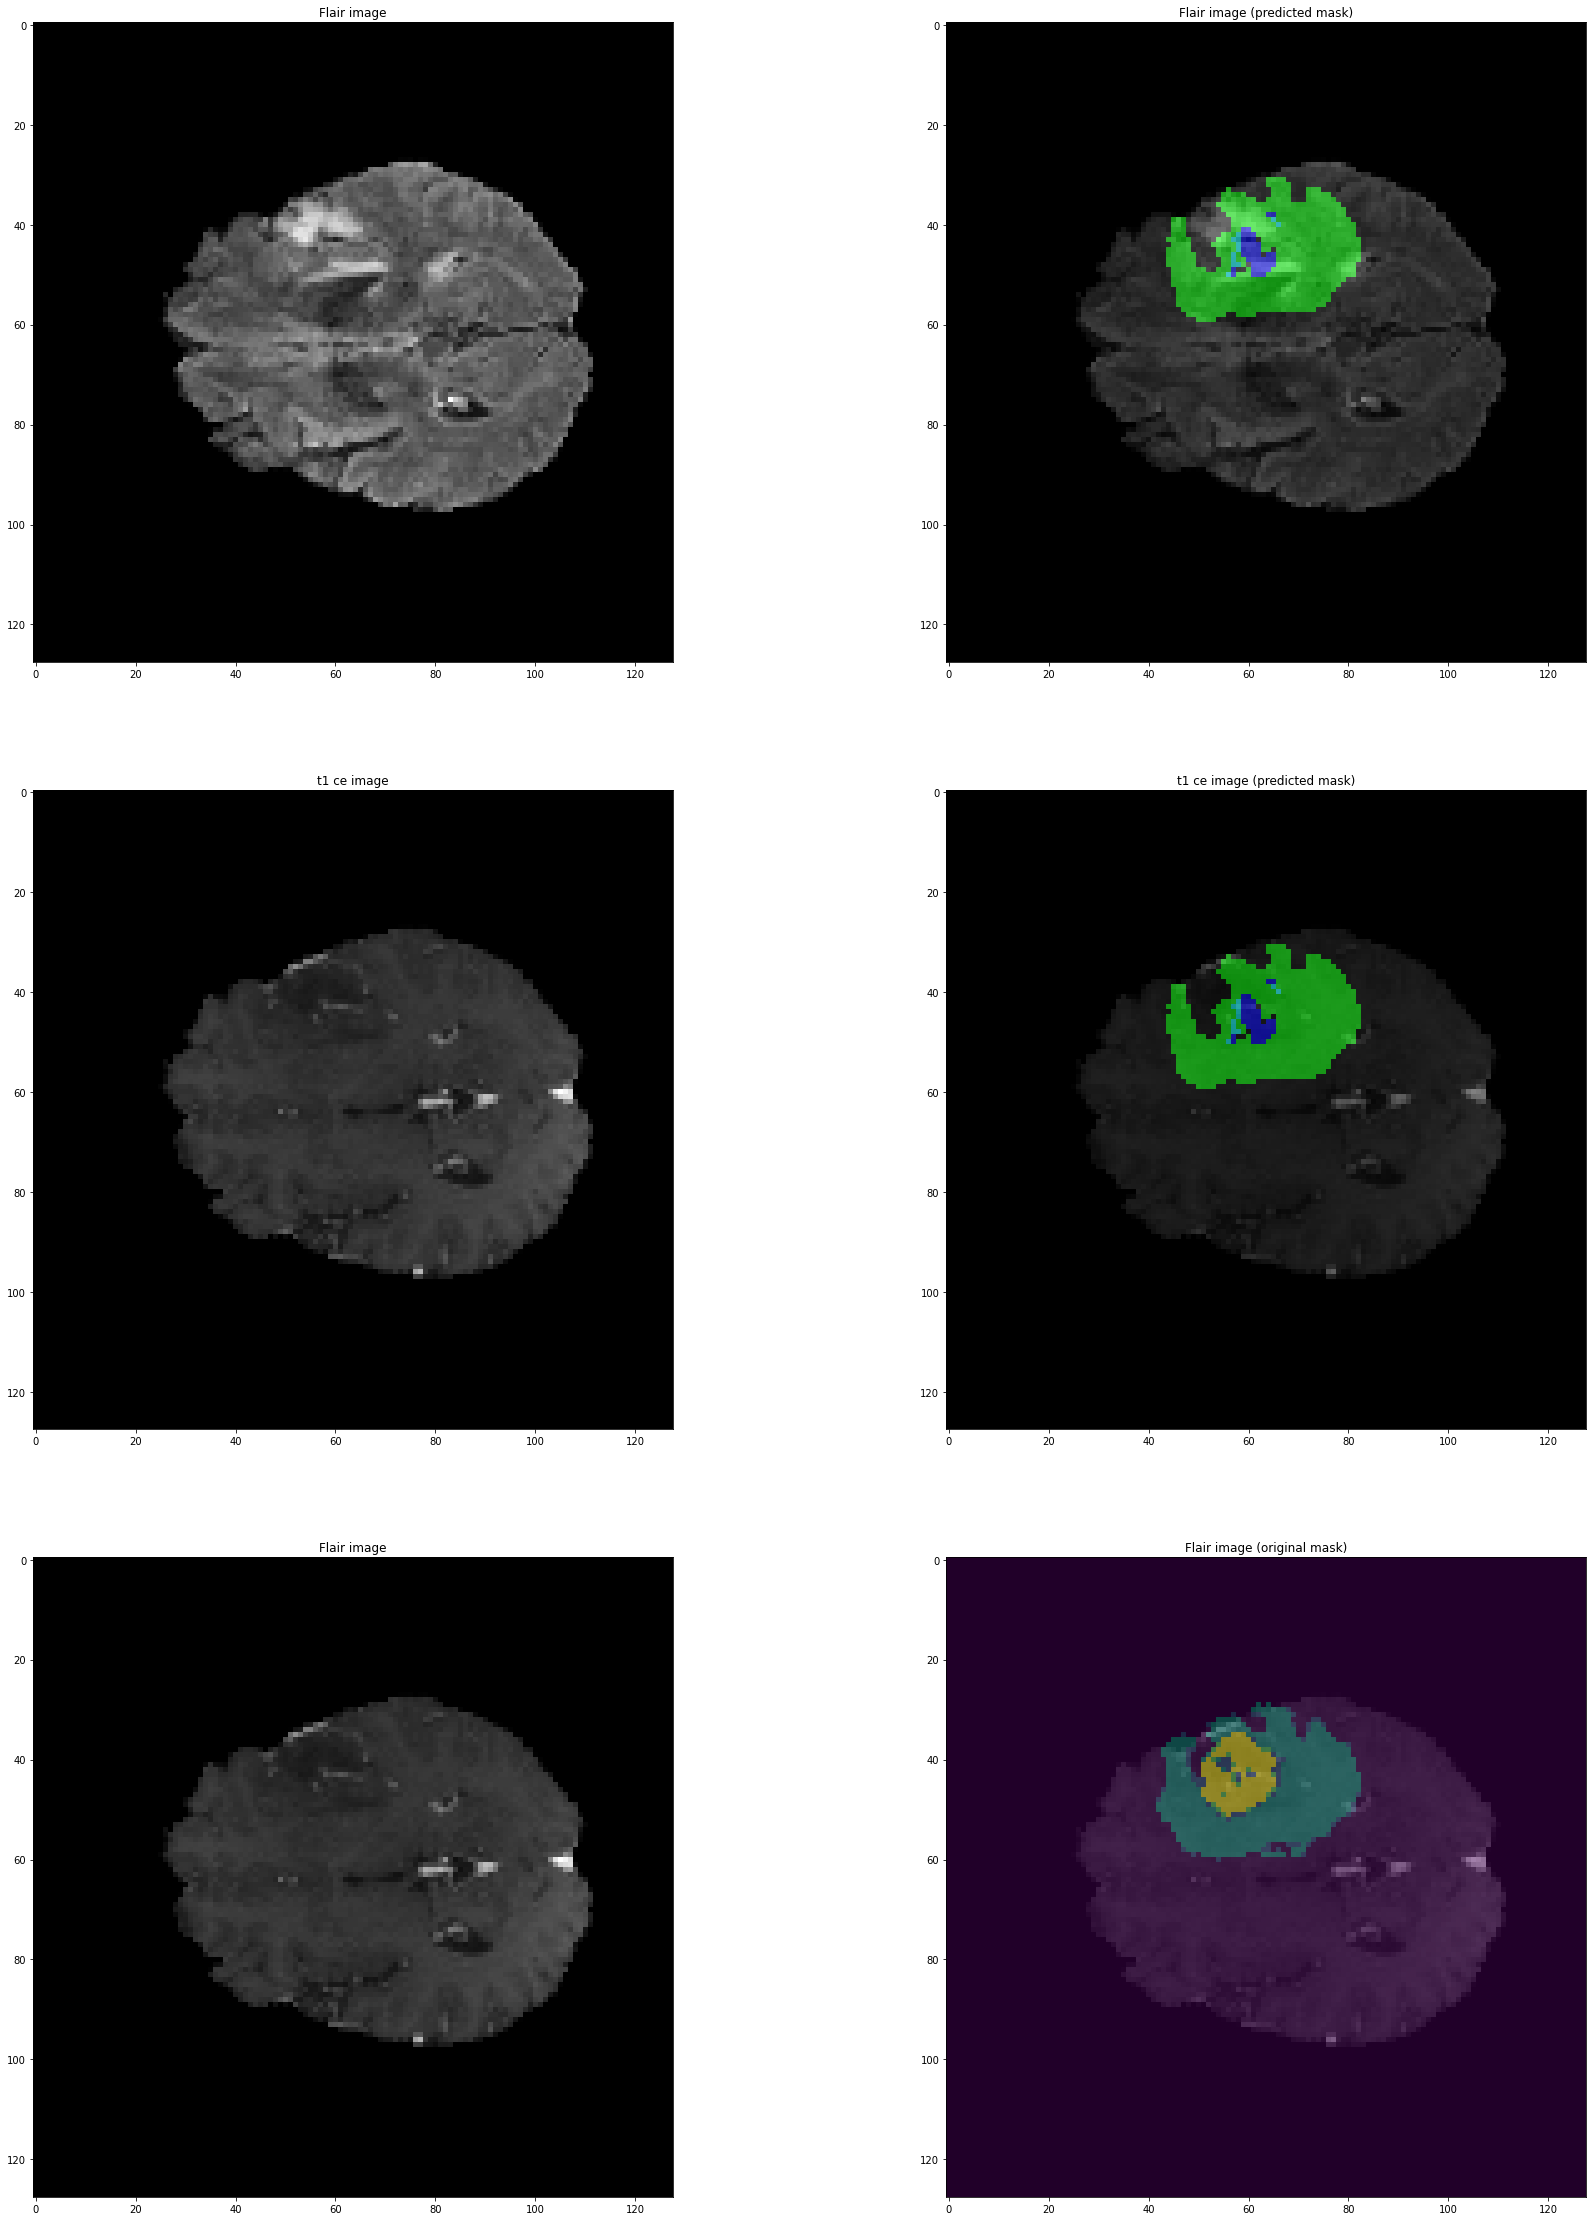

In [ ]:
import random

random_test_idx = random.randint(0, len(test_ids))
test_case = test_ids[random_test_idx]
print(test_case)
test_case = test_case[-3:]

show_mask_prediction(unet_baseline_1, case=test_case, slice_=70)